### Packages

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import pandas as pd

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.stats import norm

from utils import c2st_nn_fit, MatConvert, c2st_nn_power
from models import myLDA

### Data

In [14]:
import numpy as np
import pandas as pd

def sample_with_imbalance_2d(a_seq):
    n0 = int(500*a_seq)
    n1 = 500
    mean0 = [0, 0]
    cov0 = [[1, 0], [0, 1]]
    x0 = np.random.multivariate_normal(mean0, cov0, n0)
    x1 = np.column_stack((np.random.standard_t(3, n1), np.random.standard_t(3, n1)))
    class0 = np.repeat(0, n0)
    class1 = np.repeat(1, n1)
    x = np.concatenate((np.column_stack((x0, class0)), np.column_stack((x1, class1))))
    np.random.shuffle(x)
    df = pd.DataFrame(x, columns=["x1", "x2", "class"])
    return df


### Simulations

In [15]:
# Setup seeds 
np.random.seed(1203)
torch.manual_seed(1203)
torch.cuda.manual_seed(1203)

torch.backends.cudnn.deterministic = True
is_cuda = True

# Setup for all experiments 
dtype = torch.float
device = torch.device("cuda:1")
alpha = 0.05 # test threshold 
ir_list = [1,3,5,7,9] # imbalance ratio
x_in = 2 # number of neurons in the input layer (dimension of data)
H = 50 # number of neurons in the hidden layer
x_out = 2 # number of neurons in the output layer 
K = 1 # number of experiments
n1 = 100 # size of minority samples

In [16]:
# For each n in n_list, train deep kernel and run two-sample test
stats_a_dict = {}
stats_d_dict = {}
stats_p_dict = {}

acc_opt_cuts = []
pwr_opt_cuts = []

a_powers = {}
d_powers = {}
p_powers = {}

for r in ir_list:
    np.random.seed(1203)
    N1 = n1 * r
    N2 = n1
    batch_size = N1 + N2 # not using batch 
    n_epoch_c2st = 1200
    
    # Repeat experiments K times (K = 10) and report average test powers
    stats_a_nn = []
    stats_d_nn = []
    stats_p_nn = []
    
    for kk in range(50):
        print('='*100)
        print("\t\t\t\tImbalance Ratio: {}".format(int(N1/N2)))
        print(f"\t\t\t\tExperiments{kk+1}")
        print('='*100)
        
        np.random.seed(seed=112*kk + 1 + N1)
        data = sample_with_imbalance_2d(r)
        S = data[['x1', 'x2']].values        
        S = MatConvert(S, device, dtype)
        y = MatConvert(data['class'].values, device, dtype)
        
        # Train C2ST-L
        np.random.seed(seed=1203)
        torch.manual_seed(1203)
        torch.cuda.manual_seed(1203)
        cutvals = np.arange(start=0.001, stop=0.999, step = 0.001)
        acc, pwr, acc_opt_cut, pwr_opt_cut = c2st_nn_fit(S, y, x_in, H, x_out, cutvals, 0.01, n_epoch_c2st, batch_size, device, dtype, validation=True)
        acc_opt_cuts.append(acc_opt_cut)
        pwr_opt_cuts.append(pwr_opt_cut)
        print("-"*100)
        print('-'*100)
        print("\t\t\t\t   Testing")
        print('-'*100)
        print('-'*100)
        tau0_a, tau1_a, tau0_p, tau1_p, stat_a, stat_d, stat_p = c2st_nn_fit(S, y, x_in, H, x_out, cutvals, 0.01, n_epoch_c2st*2, batch_size, device, dtype, validation=False, acc_opt_cut=acc_opt_cut, pwr_opt_cut=pwr_opt_cut)
        
        # statistics
        stats_a_nn.append(stat_a)
        stats_d_nn.append(stat_d)
        stats_p_nn.append(stat_p)

    stats_a_dict[r] = stats_a_nn
    stats_d_dict[r] = stats_d_nn
    stats_p_dict[r] = stats_p_nn
    # power
    cr = norm.ppf(1-alpha)
    a_pwr = np.mean((stats_a_nn > (1-norm.ppf(alpha))))
    d_pwr = np.mean((stats_d_nn > (1-norm.ppf(alpha))))
    p_pwr = np.mean((stats_p_nn > (1-norm.ppf(alpha))))
    
    a_powers[r] = a_pwr
    d_powers[r] = d_pwr
    p_powers[r] = p_pwr
    print("Accuracy Power: {}".format(a_pwr), '\t', "Default Power: {}".format(d_pwr), '\t', "Power Power: {}".format(p_pwr))
    print("="*50)

				Imbalance Ratio: 1
				Experiments1
Epochs: 0	Training Binary CE Loss: 0.7546	Validation Binary CE Loss: 0.75	Training Accuracy: 0.5	Validation Accuracy: 0.5
Epochs: 100	Training Binary CE Loss: 0.6362	Validation Binary CE Loss: 0.6553	Training Accuracy: 0.604	Validation Accuracy: 0.548
Epochs: 200	Training Binary CE Loss: 0.5858	Validation Binary CE Loss: 0.684	Training Accuracy: 0.652	Validation Accuracy: 0.564
Epochs: 300	Training Binary CE Loss: 0.5443	Validation Binary CE Loss: 0.8172	Training Accuracy: 0.696	Validation Accuracy: 0.552
Epochs: 400	Training Binary CE Loss: 0.5369	Validation Binary CE Loss: 1.4197	Training Accuracy: 0.676	Validation Accuracy: 0.5
Epochs: 500	Training Binary CE Loss: 0.5157	Validation Binary CE Loss: 1.4679	Training Accuracy: 0.712	Validation Accuracy: 0.556
Epochs: 600	Training Binary CE Loss: 0.4767	Validation Binary CE Loss: 1.86	Training Accuracy: 0.728	Validation Accuracy: 0.56
Epochs: 700	Training Binary CE Loss: 0.5059	Validation Binary CE

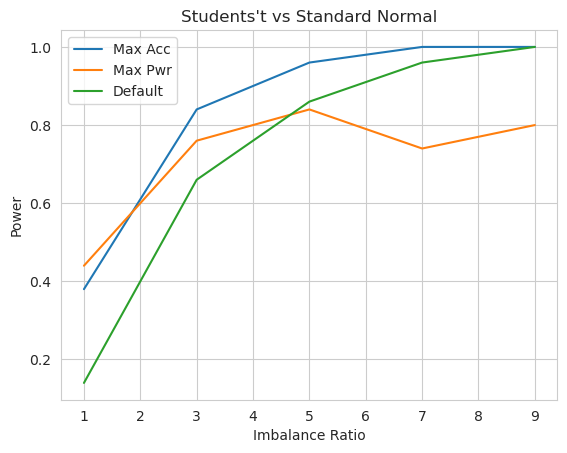

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

data_a = []
data_p = []
data_d = []
for r in ir_list:
    data_a.append({'imbalance_ratio': r, 'power': a_powers[r]})
    data_p.append({'imbalance_ratio': r, 'power': p_powers[r]})
    data_d.append({'imbalance_ratio': r, 'power': d_powers[r]})
    
        
df_a = pd.DataFrame(data_a)
df_p = pd.DataFrame(data_p)
df_d = pd.DataFrame(data_d)
# Create the plotNo
sns.set_style("whitegrid")
sns.lineplot(data=df_a, x="imbalance_ratio", y="power", label='Max Acc')
sns.lineplot(data=df_p, x="imbalance_ratio", y="power", label='Max Pwr')
sns.lineplot(data=df_d, x="imbalance_ratio", y="power", label='Default')

# Add axis labels and a title
plt.xlabel("Imbalance Ratio")
plt.ylabel("Power")
plt.title("Students't vs Standard Normal")
plt.legend()
# Show the plot
plt.show()

In [ ]:
# For each n in n_list, train deep kernel and run two-sample test
stats_a_dict = {}
stats_d_dict = {}
stats_p_dict = {}

acc_opt_cuts = []
pwr_opt_cuts = []

a_powers = {}
d_powers = {}
p_powers = {}

for r in ir_list:
    np.random.seed(1203)
    N1 = n1 * r
    N2 = n1
    batch_size = N1 + N2 # not using batch 
    n_epoch_c2st = 1000
    
    # Repeat experiments K times (K = 10) and report average test powers
    stats_a = []
    stats_d = []
    stats_p = []
    
    for kk in range(K):
        print('='*100)
        print("\t\t\t\tImbalance Ratio: {}".format(int(N1/N2)))
        print(f"\t\t\t\tExperiments{kk+1}")
        print('='*100)
        # Generate Blob-D
        np.random.seed(seed=112*kk + 1 + N1)
        s1, s2 = sample_blobs_Q(N1, N2, sigma_mx2)
        
        if kk == 0:
            s1_o = s1
            s2_o = s2
        
        S = np.concatenate((s1,s2), axis=0)
        S = MatConvert(S, device, dtype)
        
        # Train C2ST-L
        np.random.seed(seed=1203)
        torch.manual_seed(1203)
        torch.cuda.manual_seed(1203)
        y = (torch.cat((torch.zeros(N1, 1), torch.ones(N2, 1)), 0)).squeeze(1).to(device, dtype).long()
        cutvals = np.linspace(0.001, 0.999, 1000)
        pred, tau0, tau1, stat_c2st = c2st_nn_power(S, y, x_in, H, x_out, 0.01, n_epoch_c2st, batch_size, device, dtype)

In [ ]:
# For each n in n_list, train deep kernel and run two-sample test

stats = {}
powers = []
for n in n_list:
    np.random.seed(12203)
    torch.manual_seed(12203)
    torch.cuda.manual_seed(12203)
    N1 = 30 * n
    N2 = 300
    results = np.zeros([5, K])
    J_star_adp = np.zeros([K, n_epoch])
    batch_size = N1 + N2 
    n_epoch_c2st = 500
    
    # Repeat experiments K times (K = 10) and report average test power 
    stat = []
    for kk in range(K):
        print("Imbalance Ratio: {}".format(N1/N2))
        print(f"{kk+1} Experiments...")
        
        # Generate Blob-D
        np.random.seed(seed=112*kk + 1 + n)
        s1, s2 = sample_blobs_Q(N1, N2, sigma_mx2)
        
        if kk == 0:
            s1_o = s1
            s2_o = s2
        
        S = np.concatenate((s1,s2), axis=0)
        S = MatConvert(S, device, dtype)
        
        # Train C2ST-L
        np.random.seed(seed=12203)
        torch.manual_seed(12203)
        torch.cuda.manual_seed(12203)
        y = (torch.cat((torch.zeros(N1, 1), torch.ones(N2, 1)), 0)).squeeze(1).to(device, dtype).long()
        pred, tau0, tau1, stat_c2st_l, model_c2st_l, w_c2st_l, b_c2st_l = C2ST_NN_power(S, y, N1, x_in, H, x_out, 0.0005, 
                                                                          n_epoch_c2st, batch_size, device, dtype)
        # statistics
        stat.append(stat_c2st_l)
        print(pred.unique(return_counts=True))
        print(f"tau0: {tau0} \t tau1: {tau1} ", end='\t')
        print("Stats: {}".format(stat_c2st_l))
        stats[n] = stat
        
    # power
    pwr = len([i for i in stats[n] if i > (1-norm.ppf(alpha))]) / len(stats[n])
    powers.append(pwr)
    print("Power: {}".format(pwr))
    print("="*50)

In [ ]:
stats

In [ ]:
tau1

In [ ]:
stat_c2st_l

In [ ]:
pred.unique(return_counts=True)

In [ ]:
stats

In [ ]:
batch_size = 32

df = sample_blobs_Q(500, 500, sigma_mx2)

In [ ]:
# Generate data
data = sample_blobs_Q(n0=500, n1=500, sigma_mx_2=sigma_mx2)

# Split data into training and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Convert data to PyTorch tensors
train_x = torch.tensor(train_data.iloc[:, :-1].values, dtype=torch.float32)
train_y = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.int64)
test_x = torch.tensor(test_data.iloc[:, :-1].values, dtype=torch.float32)
test_y = torch.tensor(test_data.iloc[:, -1].values, dtype=torch.int64)

# Define the LeNet model
model = LeNet()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Shuffle the training data
    indices = torch.randperm(train_x.shape[0])
    train_x = train_x[indices]
    train_y = train_y[indices]
    
    # Train the model for one epoch
    model.train()
    for i in range(0, train_x.shape[0], batch_size):
        # Get the current batch of training data
        x = train_x[i:i+batch_size].reshape(-1, 1, 2, 1)
        y = train_y[i:i+batch_size]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df.drop("class", axis=1), df["class"], test_size=0.5, random_state=42)
# X_train = torch.from_numpy(X_train.to_numpy().reshape(-1, 1, 3, 3)).float()
# y_train = torch.from_numpy(y_train.to_numpy()).float()
# X_test = torch.from_numpy(X_test.to_numpy().reshape(-1, 1, 3, 3)).float()
# y_test = torch.from_numpy(y_test.to_numpy()).float()

In [ ]:
model = LeNet()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, loss: {running_loss/len(train_loader)}")

In [ ]:
# set up training parameters
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('[Epoch %d] Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

# predict on the test set
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.detach().cpu().numpy().flatten())
y_pred = np.concatenate(y_pred)

# compute power function
tau_0 = np.mean(y_test[y_test == 0])
tau_1 = np.mean(y_test[y_test == 1])
n0 = len(y_test[y_test == 0])
n1 = len(y_test[y_test == 1])
sigma_mx_2 = get_sigma_mx2(n0, n1, y_test, y_pred)
se = np.sqrt(tau_1*(1-tau_1)/n1 + tau_0*(1-tau_0)/n0)
power = norm.cdf((norm.ppf(0.8) - se*np.sqrt(sigma_mx_2.sum()))/np.sqrt(sigma_mx_2.sum()))
print('Power:', power)